## Python Project --- How well do expected goals (xg) match up with the outcome of games and seasons in the English Premier League?

The goal of this project is to analyze whether expected goals (xg) matches the results of an individual game or on a larger scale a season.  All result and figures are from 3 seasons of the English Premier League (EPL).

Libraries used in this project.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Code used to read csv file and create data frame for the project.
Excludes data in the csv file that will not be used in the project. Gives example of how data is currently structured.

In [2]:
df = pd.read_csv('spi_matches.csv')
df = df[df.league == "Barclays Premier League"]
df.head() [['date', 'team1', 'team2', 'score1', 'score2', 'xg1', 'xg2', 'league']]

,date,team1,team2,score1,score2,xg1,xg2,league
2,2016-08-13,Hull City,Leicester City,2.0,1.0,0.85,2.77,Barclays Premier League
3,2016-08-13,Everton,Tottenham Hotspur,1.0,1.0,0.73,1.11,Barclays Premier League
4,2016-08-13,Burnley,Swansea City,0.0,1.0,1.24,1.84,Barclays Premier League
5,2016-08-13,Crystal Palace,West Bromwich Albion,0.0,1.0,1.11,0.68,Barclays Premier League
6,2016-08-13,Middlesbrough,Stoke City,1.0,1.0,1.40,0.55,Barclays Premier League


Creating the database for the EPL (English Premier League) table

In [3]:
df.to_sql("epl_table", sqlite3.connect("epl.db"), if_exists = "replace")

Connecting to the database and querying back the information with SQL

In [4]:
con = sqlite3.connect("epl.db")
df = pd.read_sql_query("SELECT date, team1, team2, score1, score2, xg1, xg2 FROM epl_table", con)
df.head()

,date,team1,team2,score1,score2,xg1,xg2
0,2016-08-13,Hull City,Leicester City,2.0,1.0,0.85,2.77
1,2016-08-13,Everton,Tottenham Hotspur,1.0,1.0,0.73,1.11
2,2016-08-13,Burnley,Swansea City,0.0,1.0,1.24,1.84
3,2016-08-13,Crystal Palace,West Bromwich Albion,0.0,1.0,1.11,0.68
4,2016-08-13,Middlesbrough,Stoke City,1.0,1.0,1.40,0.55


#### Examining how xg does at matching the outcome of each game.

First a query to examine the amount of wins, draws, and ties in our data set. A win is when score1 > score2 (a home team win), a loss is when score1 < score2 (an away team win) and a tie when score1 and score2 are equal.

<BarContainer object of 3 artists>

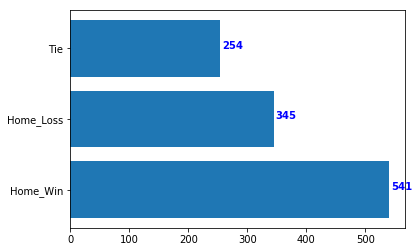

In [5]:
outcome = pd.read_sql_query("""
SELECT
    count(CASE WHEN score1 > score2
       then 1 END) as Home_Win,
    count(CASE WHEN score1 < score2
       then 1 END) as Home_Loss,
    count(CASE WHEN score1 == score2 
       then 1 END) as Tie
FROM epl_table""", con)
labels = outcome.loc[0].index
values = outcome.loc[0].values
fig, ax = plt.subplots()
for i, v in enumerate(values):
    ax.text(v + 3, i, str(v), color='blue', fontweight='bold')
plt.barh(labels, values)

So much for those who say soccer always ends in a boring tie as 77.7% of the matches have a winning team. The home team also wins at a rate of 47.46% which would seem to indicate that a home field advantage exists.

Next- SQL query to bring back data for the scores and xg of each game. Query sorts each game into category to see if xg correctly matched the actual outcome.

Correct win, loss, and tie - means xg was right in the outcome. **Since xg would almost never be exactly equal to predict a tie a difference of .5 xg between the teams would qualify as an xg tie**

Incorrect means that xg did not correctly match the outcome of the actual game based on the same parameters.

Below is a short look at how the data is returned. Then below that the count of each game and whether xg correctly matched the result. It then takes those counts and presents them in a horizontal bar graph.

In [6]:
xg_outcome = pd.read_sql_query("""
SELECT score1, score2, xg1, xg2,
   CASE
    WHEN score1 > score2 and xg1 > (xg2 + .5) then
        'correct home win'
    WHEN score1 < score2 and (xg1 + .5) < xg2 then
        'correct home loss'
    WHEN score1 == score2 and abs(xg1 - xg2) <= .5 then
        'correct tie'
    WHEN score1 > score2 and xg1 < (xg2 + .5) then
        'incorrect home win'
    WHEN score1 < score2 and (xg1 + .5) > xg2 then
        'incorrect home loss'
    ELSE
        'incorrect tie' 
    END category
FROM epl_table""", con)
xg_outcome.head()

,score1,score2,xg1,xg2,category
0,2.0,1.0,0.85,2.77,incorrect home win
1,1.0,1.0,0.73,1.11,correct tie
2,0.0,1.0,1.24,1.84,correct home loss
3,0.0,1.0,1.11,0.68,incorrect home loss
4,1.0,1.0,1.40,0.55,incorrect tie


<BarContainer object of 6 artists>

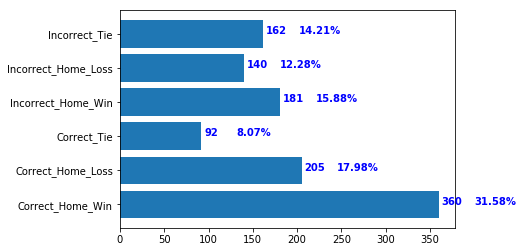

In [7]:
xg_outcome_count = pd.read_sql_query("""
SELECT
    count(CASE WHEN score1 > score2 and xg1 >= (xg2 + .5) 
       then 1 END) as Correct_Home_Win,
    count(CASE WHEN score1 < score2 and (xg1 + .5) <= xg2
       then 1 END) as Correct_Home_Loss,
    count(CASE WHEN score1 == score2 and abs(xg1 - xg2) <= .5
       then 1 END) as Correct_Tie,
    count(CASE WHEN score1 > score2 and xg1 < (xg2 + .5)
       then 1 END) as Incorrect_Home_Win,
    count(CASE WHEN score1 < score2 and (xg1 + .5) > xg2
       then 1 END) as Incorrect_Home_Loss,
    count(CASE WHEN score1 == score2 and abs(xg1 - xg2) > .5
       then 1 END) as Incorrect_Tie
FROM epl_table""", con)
labels = xg_outcome_count.loc[0].index
total = sum(xg_outcome_count.loc[0].values)
values = xg_outcome_count.loc[0].values
fig, ax = plt.subplots()
for i, v in enumerate(values):
    ax.text(v + 3, i, str(v), color='blue', fontweight='bold')
for y, p in enumerate(values):
    ax.text(p + 40, y, str(round((p / total)*100, 2)) + '%', color='blue', fontweight='bold')
plt.barh(labels, values)

By these metrics xg matches the correct result of the game 57.63% of the time. When the home team wins a game (541 games/48% of the data set) xg matches the outcome correctly 66.5% of the time. 
When the home team loses a game (345 games/30% of the data set) xg matches the outcome correctly 59.4% of the time. When the outcome is a tie (254 games/22% of the data set) xg matches the outcome correctly 36% of the time.

Now we will look at the actual data a little more in depth since we have a base level understanding of how the xg results match up with the actual results.

In [8]:
average = pd.read_sql_query("SELECT avg(score1), avg(score2), avg(xg1), avg(xg2) FROM epl_table", con)
average

,avg(score1),avg(score2),avg(xg1),avg(xg2)
0,1.565789,1.200877,1.554132,1.214456


The df above above shows on average the home team scores around .3 more than the away team regardless of the teams involved. Since each EPL season consists of each team playing the others twice (home and away) this would seem to indicate that a home field advantage does exist within the English Premier League.

Another interesting insight is that the score and xg data are extremely accurate over the course of the 3 seasons in this data set.

Now we will plot our data points with the darker dots representing results that appear more often.

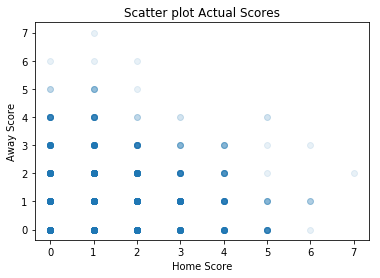

In [9]:
scatter_actual = pd.read_sql_query("SELECT score1, score2 FROM epl_table", con)

h_score = scatter_actual['score1']
a_score = scatter_actual['score2']

plt.scatter(h_score, a_score, alpha=0.1)
plt.title('Scatter plot Actual Scores')
plt.xlabel('Home Score')
plt.ylabel('Away Score')
plt.show()

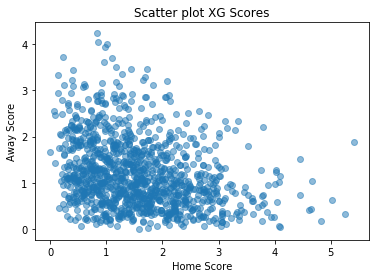

In [10]:
scatter_xg = pd.read_sql_query("SELECT xg1, xg2 FROM epl_table", con)

hx_score = scatter_xg['xg1']
ax_score = scatter_xg['xg2']

plt.scatter(hx_score, ax_score, alpha=0.5)
plt.title('Scatter plot XG Scores')
plt.xlabel('Home Score')
plt.ylabel('Away Score')
plt.show()

From the scatter plots there isn't a lot of difference in the overall shape of each graph. Both have most results ranging on the lower end of the spectrum of goals scored (1 or 2 ususally). The difference in the plots is more at the edges. 

In [11]:
outer_edge_cases = pd.read_sql_query("""
SELECT
    count(CASE WHEN score1 == 0 and score2 == 0 
       then 1 END) as Boring_Tie,
    count(CASE WHEN xg1 <= 0.5 and xg2 <= 0.5 
       then 1 END) as Boring_XG_Tie,
    count(CASE WHEN score1 >= 5 or score2 >= 5
       then 1 END) as Wow_Goals,
    count(CASE WHEN xg1 >= 5 or xg2 >= 5
       then 1 END) as Wow_XG_Goals  
    FROM epl_table""", con)
outer_edge_cases

,Boring_Tie,Boring_XG_Tie,Wow_Goals,Wow_XG_Goals
0,81,7,49,3


This takes a look at the outer edges of the results. The xg map is sparse at stating a result should have been a 0-0 draw (only 7 times) while it is a somewhat common outcome in the actual score (81 times or 7% of the data set). Again the actual scores show cases of a team scoring over 5 goals 49 times while xg only thought that would happen 3 times based on the chances of the game. I don't think one can call these 2 cases of actual outcomes outliers either as the comprise 11.4% of the total data set. XG only shows this happening in its metric 0.8%.

Now we will try to take a closer look at how XG matches up with a whole season's results.  This next section queries only the teams involved in the 2018-2019 season.  It then passes these teams into a for loop to determine how the actual points accured (win is worth 3 pts, tie is worth 1 pt, loss is worth 0 pts) match up with the xg pts accured.  

In [15]:
teamsUnique = pd.read_sql_query("""
    SELECT DISTINCT team1 FROM epl_table WHERE date BETWEEN '2018-08-01' AND '2019-06-01'""", con)
teamsList = teamsUnique.iloc[:,0].tolist()
def seasonComp(list):
    for i in list:
         query1 = pd.read_sql_query("""
            SELECT 
                count(CASE WHEN score1 == score2 
                    then 1 END) as Tie,
                count(CASE WHEN score1 > score2
                    then 1 END)*3 as Win
                FROM epl_table WHERE team1='{}' and date BETWEEN '2018-08-01' AND '2019-06-01'
                """.format(i), con)
         query2 = pd.read_sql_query("""
            SELECT 
                count(CASE WHEN score1 == score2 
                    then 1 END) as Tie,
                count(CASE WHEN score1 < score2
                    then 1 END)*3 as Win
                FROM epl_table WHERE team2='{}' and date BETWEEN '2018-08-01' AND '2019-06-01'
                """.format(i), con)
         queryxg1 = pd.read_sql_query("""
            SELECT 
                count(CASE WHEN abs(xg1 - xg2) <= .5 
                    then 1 END) as Tie, 
                count(CASE WHEN xg1 > (xg2 + .5) 
                    then 1 END)*3 as Win 
                FROM epl_table WHERE team1='{}' and date BETWEEN '2018-08-01' AND '2019-06-01'
                """.format(i), con)
         queryxg2 = pd.read_sql_query("""
            SELECT 
                count(CASE WHEN abs(xg1 - xg2) <= .5
                    then 1 END) as Tie,
                count(CASE WHEN (xg1 + .5) < xg2
                    then 1 END)*3 as Win
                FROM epl_table WHERE team2='{}' and date BETWEEN '2018-08-01' AND '2019-06-01'
                """.format(i), con)
         print(i, (sum(query1.loc[0].values) + sum(query2.loc[0].values)), (sum(queryxg1.loc[0].values) + sum(queryxg2.loc[0].values)), (sum(query1.loc[0].values) + sum(query2.loc[0].values)) - (sum(queryxg1.loc[0].values) + sum(queryxg2.loc[0].values)))

seasonComp(teamsList)

Manchester United 66 61 5
Newcastle 45 31 14
AFC Bournemouth 45 47 -2
Huddersfield Town 16 21 -5
Watford 50 46 4
Fulham 26 26 0
Wolverhampton 57 61 -4
Liverpool 97 92 5
Southampton 39 39 0
Arsenal 70 60 10
Cardiff City 34 30 4
Everton 54 55 -1
Tottenham Hotspur 71 68 3
West Ham United 52 41 11
Leicester City 52 55 -3
Chelsea 72 85 -13
Manchester City 98 99 -1
Burnley 40 37 3
Brighton and Hove Albion 36 32 4
Crystal Palace 49 47 2


It seems that XG is hit and miss on matching the final point total.  2 of the results are right on and 14 of the results are within +/- 5 pts of the final tally.  The other 4 results are well off the mark with a difference of 14, 10, 11, and -13 respectively.

When we organize the data by the actual final points accumulated we see that the final table matches up well. Chelsea's xg predicted 13 more points for them but they would still have been 3rd place.  Newcastle has the largest move as the overshot their xg results by 14 finishing tied for 13th when XG had them as finishing 17th.

## In Conclusion
From all this xg doesn't seem like a great way to match a single games' outcome considering it only matches the correct result 57% of the time.  It also doesn't pickup well on the cases at the outer edges of the scores (0-0 or 6-3) while in actuality these cases happen a decent amount of the time.

However from the metrics we have explored so far xg does seem to closely follow the actual results on a whole over the course of a season.  The averages of xg and actual scores is very close over the course of the time span.  And when plotting out the data points the scatter plots are very similar.  Over the course of a season XG matches the results of the final table pretty well even if the points totals are off here and there.

At the end of this analysis I believe the xg is a metric that is beneficial to analyzing a larger span of time or seasons than it is for analyzing each individual game. 